In [57]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
from tqdm import tqdm

pd.options.display.max_colwidth = 200

import nltk
from nltk import word_tokenize, ngrams
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer

from fuzzywuzzy import fuzz

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


snow=nltk.stem.SnowballStemmer('english')

stop_words = set(stopwords.words('english'))
ps = PorterStemmer()




In [2]:
df = pd.read_csv("../data/raw/train.csv")

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0


In [4]:
df.shape

(404290, 6)

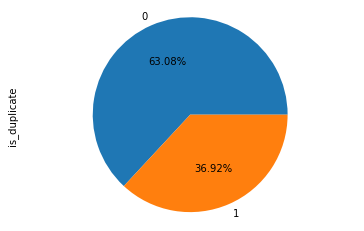

In [5]:
df.is_duplicate.value_counts().plot(kind='pie', autopct='%1.2f%%')
plt.axis('equal')
plt.show()

In [6]:
df_all_question = pd.DataFrame(pd.concat([df.question1, df.question2])).reset_index(drop=True)
df_all_question.columns = ['questions']

In [7]:
df_all_question['word_count'] = df_all_question['questions'].apply(lambda x : len(str(x).split()))
df_all_question['character_count'] = df_all_question['questions'].apply(lambda x : len(str(x)))

In [8]:
word_distribution = df_all_question['word_count'].value_counts()
character_distribution = df_all_question['character_count'].value_counts()

In [10]:
df_all_question[['word_count', 'character_count']].describe()

,word_count,character_count
count,808580.000000,808580.000000
mean,11.062100,59.822548
std,5.884595,31.963751
min,1.000000,1.000000
25%,7.000000,39.000000
50%,10.000000,51.000000
75%,13.000000,72.000000
max,237.000000,1169.000000


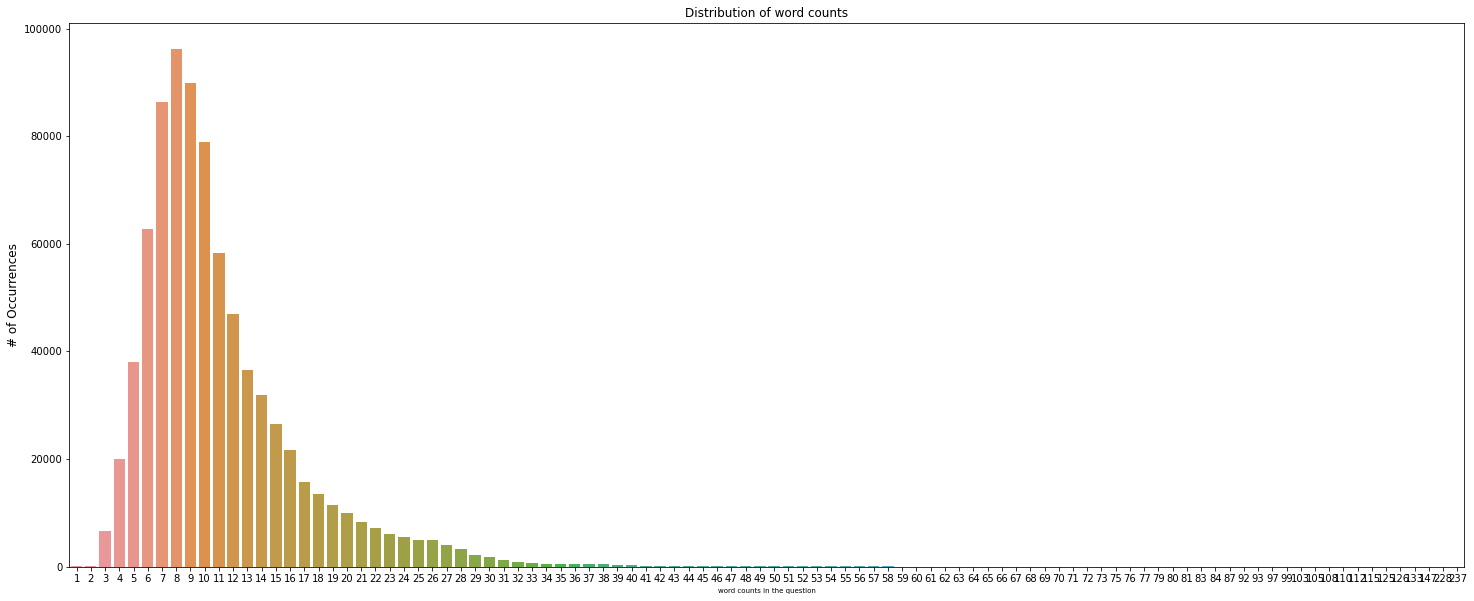

In [11]:
plt.subplots(figsize = (25,10))
sns.barplot(x = word_distribution.index, y = word_distribution.values)
plt.title('Distribution of word counts')
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('word counts in the question', fontsize=7)
plt.show()

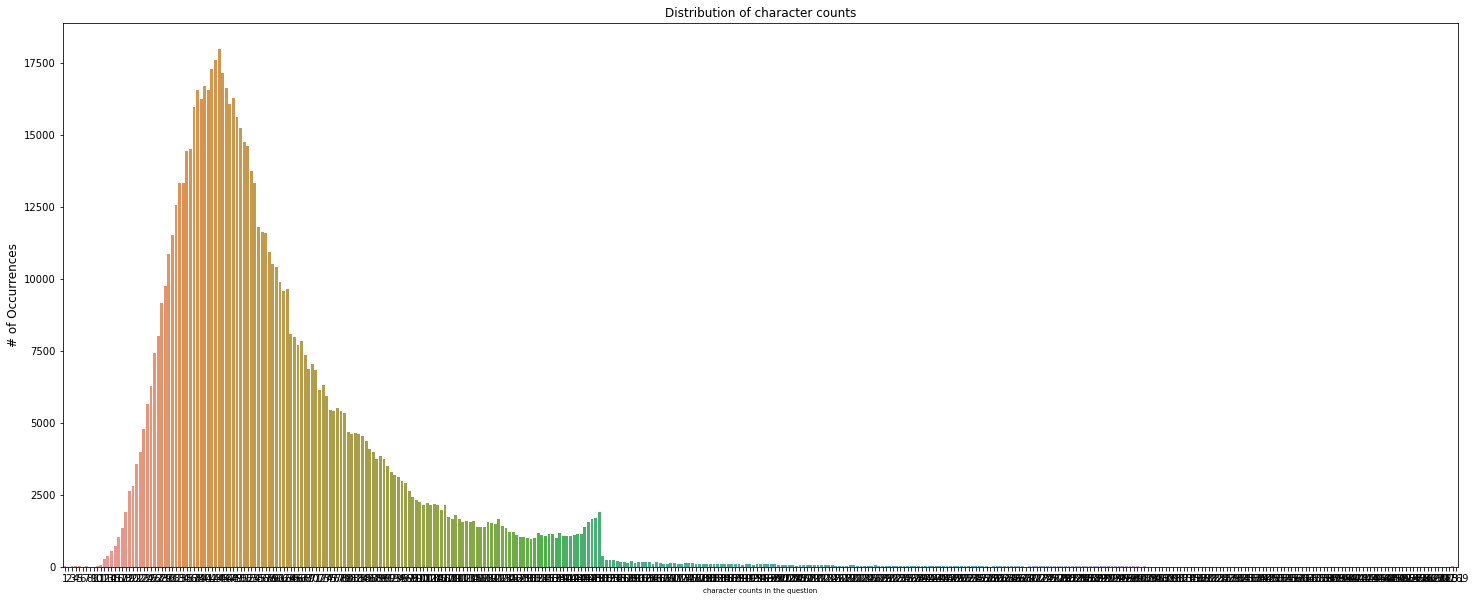

In [12]:
fig,ax = plt.subplots(figsize = (25,10))
sns.barplot(x = character_distribution.index, y = character_distribution.values, ax=ax)

# ax.set_xticks(character_distribution.index) # <--- set the ticks first
# ax.set_xticklabels(np.arange(min(character_distribution.index), max(character_distribution.index)+1, 100))
plt.title('Distribution of character counts')
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('character counts in the question', fontsize=7)
# plt.xticks(np.arange(min(character_distribution.index), max(character_distribution.index)+1, 100))
plt.show()

In [13]:
df_clean = df[(df.question1.str.len() >9) & (df.question2.str.len() >9)]

In [14]:
def cleaning(s):
    s = str(s)
    s = s.lower()
    s = re.sub('\s\W',' ',s)
    s = re.sub('\W,\s',' ',s)
    s = re.sub(r'[^\w]', ' ', s)
    s = re.sub("\d+", "", s)
    s = re.sub('\s+',' ',s)
    s = re.sub('[!@#$_\?]', '', s)
    s = s.replace("co","")
    s = s.replace("https","")
    s = s.replace(",","")
    s = s.replace("[\w*"," ")
    s = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", s)
    s = re.sub(r"what's", "what is ", s)
    s = re.sub(r"\'s", " ", s)
    s = re.sub(r"\'ve", " have ", s)
    s = re.sub(r"can't", "cannot ", s)
    s = re.sub(r"n't", " not ", s)
    s = re.sub(r"i'm", "i am ", s)
    s = re.sub(r"\'re", " are ", s)
    s = re.sub(r"\'d", " would ", s)
    s = re.sub(r"\'ll", " will ", s)
    s = re.sub(r",", " ", s)
    s = re.sub(r"\.", " ", s)
    s = re.sub(r"!", " ! ", s)
    s = re.sub(r"\/", " ", s)
    s = re.sub(r"\^", " ^ ", s)
    s = re.sub(r"\+", " + ", s)
    s = re.sub(r"\-", " - ", s)
    s = re.sub(r"\=", " = ", s)
    s = re.sub(r"'", " ", s)
    s = re.sub(r"(\d+)(k)", r"\g<1>000", s)
    s = re.sub(r":", " : ", s)
    s = re.sub(r" e g ", " eg ", s)
    s = re.sub(r" b g ", " bg ", s)
    s = re.sub(r" u s ", " american ", s)
    s = re.sub(r"\0s", "0", s)
    s = re.sub(r" 9 11 ", "911", s)
    s = re.sub(r"e - mail", "email", s)
    s = re.sub(r"j k", "jk", s)
    s = re.sub(r"\s{2,}", " ", s)
    s = re.sub(r"what's", "", s)
    s = re.sub(r"\'s", " ", s)
    s = re.sub(r"\'ve", " have ", s)
    s = re.sub(r"can't", "cannot ", s)
    s = re.sub(r"n't", " not ", s)
    s = re.sub(r" m ", " am ", s)
    s = re.sub(r"\'re", " are ", s)
    s = re.sub(r"\'d", " would ", s)
    s = re.sub(r"60k", " 60000 ", s)
    s = re.sub(r"\0s", "0", s)
    s = re.sub(r"e-mail", "email", s)
    s = re.sub(r"\s{2,}", " ", s)
    s = re.sub(r"quikly", "quickly", s)
    s = re.sub(r" usa ", " america ", s)
    s = re.sub(r" uk ", " england ", s)
    s = re.sub(r"imrovement", "improvement", s)
    s = re.sub(r"intially", "initially", s)
    s = re.sub(r" dms ", "direct messages ", s)  
    s = re.sub(r"demonitization", "demonetization", s) 
    s = re.sub(r"actived", "active", s)
    s = re.sub(r"kms", " kilometers ", s)
    s = re.sub(r" cs ", " computer science ", s) 
    s = re.sub(r" upvotes ", " up votes ", s)
    s = re.sub(r" iPhone ", " phone ", s)
    s = re.sub(r"\0rs ", " rs ", s) 
    s = re.sub(r"calender", "calendar", s)
    s = re.sub(r"ios", "operating system", s)
    s = re.sub(r"gps", "GPS", s)
    s = re.sub(r"gst", "GST", s)
    s = re.sub(r"programing", "programming", s)
    s = re.sub(r"bestfriend", "best friend", s)
    s = re.sub(r"III", "3", s) 
    s = re.sub(r"the us", "america", s)
    return s
df_clean['question1'] = [cleaning(s) for s in df_clean['question1']]
df_clean['question2'] = [cleaning(s) for s in df_clean['question2']]

<ipython-input-14-27a40e693619>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['question1'] = [cleaning(s) for s in df_clean['question1']]
<ipython-input-14-27a40e693619>:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['question2'] = [cleaning(s) for s in df_clean['question2']]


In [15]:
qids = pd.Series(df_clean['qid1'].tolist() + df_clean['qid2'].tolist()) #adding two lists [1,2,3,4] + [2,3,4] gives [1,2,3,4,2,3,4]
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537795

Number of unique questions that appear more than one time: 111741 (20.777619724988146%)

Max number of times a single question is repeated: 157



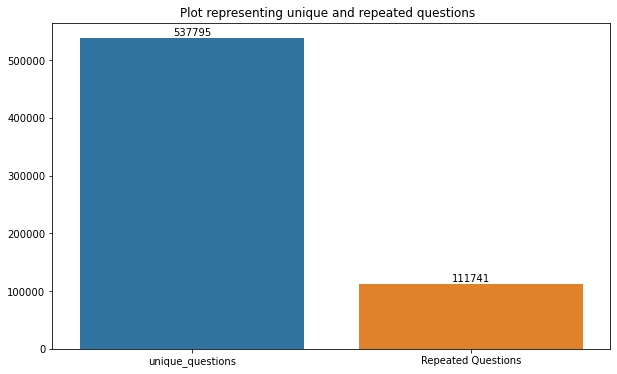

In [16]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]



fig,ax = plt.subplots(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y, ax=ax)

for index, row in enumerate(y):
    ax.text(index,row+5000, row, color='black', ha="center")

plt.show()

Maximum number of times a single question is repeated: 157



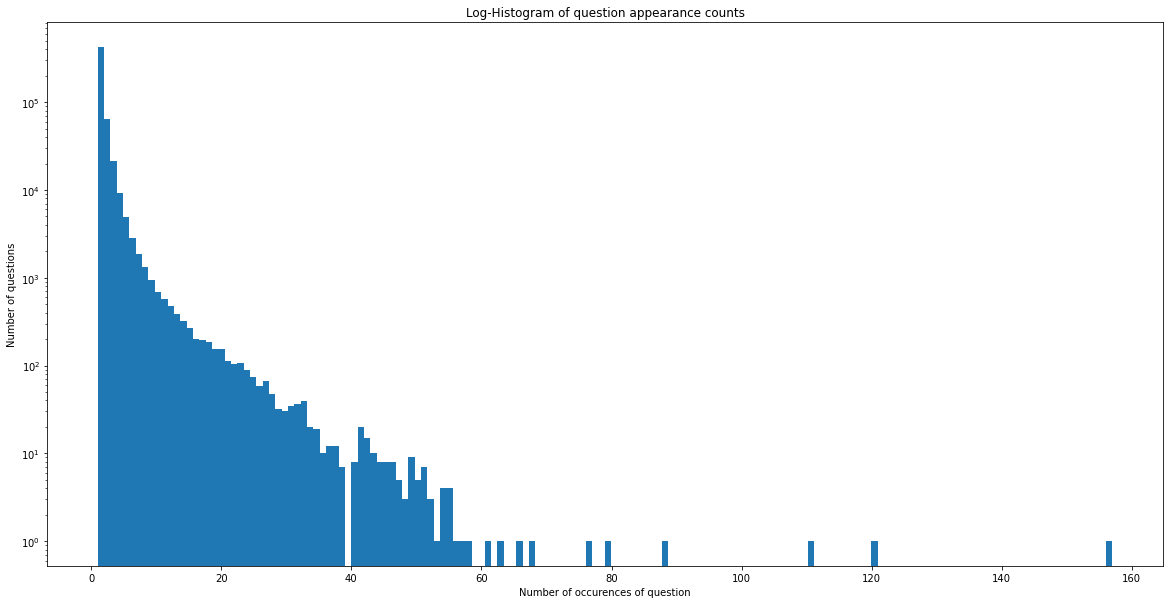

In [17]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

In [19]:
def get_unigram(question):
    return [word for word in word_tokenize(question.lower()) if word not in stop_words]

In [20]:
df_clean['unigram_ques1'] = df_clean['question1'].apply(lambda x : list(set(get_unigram(str(x)))))
df_clean['unigram_ques2'] = df_clean['question2'].apply(lambda x : list(set(get_unigram(str(x)))))

<ipython-input-20-1d5888ff064d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['unigram_ques1'] = df_clean['question1'].apply(lambda x : list(set(get_unigram(str(x)))))
<ipython-input-20-1d5888ff064d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['unigram_ques2'] = df_clean['question2'].apply(lambda x : list(set(get_unigram(str(x)))))


In [21]:
df_clean['q1len'] = df_clean['question1'].str.len() 
df_clean['q2len'] = df_clean['question2'].str.len()
df_clean['q1_n_words'] = df_clean['question1'].apply(lambda row: len(row.split(" ")))
df_clean['q2_n_words'] = df_clean['question2'].apply(lambda row: len(row.split(" ")))

<ipython-input-21-5fe336ed6076>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['q1len'] = df_clean['question1'].str.len()
<ipython-input-21-5fe336ed6076>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['q2len'] = df_clean['question2'].str.len()
<ipython-input-21-5fe336ed6076>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

In [22]:
df_clean.head()

,id,qid1,qid2,question1,question2,is_duplicate,unigram_ques1,unigram_ques2,q1len,q2len,q1_n_words,q2_n_words
0,0,1,2,what is the step by step guide to invest in share market in india,what is the step by step guide to invest in share market,0,"[guide, share, india, step, invest, market]","[guide, share, step, invest, market]",66,57,15,13
1,1,3,4,what is the story of kohinoor koh i noor diamond,what would happen if the indian government stole the kohinoor koh i noor diamond back,0,"[kohinoor, diamond, story, koh, noor]","[kohinoor, diamond, indian, would, happen, government, koh, back, noor, stole]",49,86,11,16
2,2,5,6,how can i increase the speed of my internet nnection while using a vpn,how can internet speed be increased by hacking through dns,0,"[increase, nnection, speed, vpn, internet, using]","[increased, speed, dns, internet, hacking]",71,59,15,11
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math math is divided by,0,"[lonely, solve, mentally]","[divided, find, math, remainder]",49,48,12,10
4,4,9,10,which one dissolve in water quickly sugar salt methane and carbon di oxide,which fish would survive in salt water,0,"[one, methane, sugar, carbon, oxide, di, salt, dissolve, water, quickly]","[fish, would, survive, salt, water]",75,39,14,8


In [25]:
df_clean[(df_clean['unigram_ques1'].apply(lambda x: len(x)) ==0) | (df_clean['unigram_ques2'].apply(lambda x: len(x)) ==0) ]

,id,qid1,qid2,question1,question2,is_duplicate,unigram_ques1,unigram_ques2,q1len,q2len,q1_n_words,q2_n_words
918,918,1831,1832,i am what should i do,what can i do when i am,1,[],[],22,24,7,8
1510,1510,3007,3008,if and what is,why can i not multiply fractions in python,0,[],"[python, fractions, multiply]",15,43,5,9
7120,7120,13921,13922,is it proper to use a mma after saying thank you,what is here and not there,0,"[use, thank, mma, saying, proper]",[],49,27,12,7
7368,7368,14396,14397,what is,what is,0,[],[],8,8,3,3
7820,7820,15264,15265,why and how is,why is equal to,1,[],[equal],15,16,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...
395737,395737,99189,92105,can we prove,how is,1,[prove],[],13,7,4,3
400030,400030,533354,533355,can i teach my self intermediate algebra in months,if than,0,"[teach, self, months, intermediate, algebra]",[],51,8,10,3
400269,400269,95567,533614,what is,if i what will i i do to i,0,[],[],8,27,3,10
401878,401878,182142,535325,what is is it one zero or infinity,what is,0,"[one, infinity, zero]",[],35,8,9,3


In [27]:
def get_common_word_ratio(row):
    return row['word_share'] / max(len(list(set((row['unigram_ques1'] + row['unigram_ques2'])))),1)

def get_common_unigram(row):
    return len(set(row['unigram_ques1']).intersection(set(row['unigram_ques2'])))

In [24]:
df_clean2 = df_clean.drop(df_clean[(df_clean['unigram_ques1'].apply(lambda x: len(x)) ==0) | 
                                   (df_clean['unigram_ques2'].apply(lambda x: len(x)) ==0) ].index, axis=0)

In [28]:
df_clean2['word_share'] = df_clean2.apply(lambda x : get_common_unigram(x), axis=1)

In [29]:
df_clean2['common_word_ratio'] = df_clean2.apply(lambda x: get_common_word_ratio(x), axis =1)

In [30]:
df_clean2.head()

,id,qid1,qid2,question1,question2,is_duplicate,unigram_ques1,unigram_ques2,q1len,q2len,q1_n_words,q2_n_words,word_share,common_word_ratio
0,0,1,2,what is the step by step guide to invest in share market in india,what is the step by step guide to invest in share market,0,"[guide, share, india, step, invest, market]","[guide, share, step, invest, market]",66,57,15,13,5,0.833333
1,1,3,4,what is the story of kohinoor koh i noor diamond,what would happen if the indian government stole the kohinoor koh i noor diamond back,0,"[kohinoor, diamond, story, koh, noor]","[kohinoor, diamond, indian, would, happen, government, koh, back, noor, stole]",49,86,11,16,4,0.363636
2,2,5,6,how can i increase the speed of my internet nnection while using a vpn,how can internet speed be increased by hacking through dns,0,"[increase, nnection, speed, vpn, internet, using]","[increased, speed, dns, internet, hacking]",71,59,15,11,2,0.222222
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math math is divided by,0,"[lonely, solve, mentally]","[divided, find, math, remainder]",49,48,12,10,0,0.000000
4,4,9,10,which one dissolve in water quickly sugar salt methane and carbon di oxide,which fish would survive in salt water,0,"[one, methane, sugar, carbon, oxide, di, salt, dissolve, water, quickly]","[fish, would, survive, salt, water]",75,39,14,8,2,0.153846


In [31]:
unigram_common_words = df_clean2['word_share'].value_counts()

In [32]:
print(df_clean2.word_share.min())
print(df_clean2.word_share.mean())
print(df_clean2.word_share.max())


print(len(df_clean2[df_clean2.word_share==0]))
print(len(df_clean2[df_clean2.word_share!=0]))

0
2.447967105328303
23
42399
361557


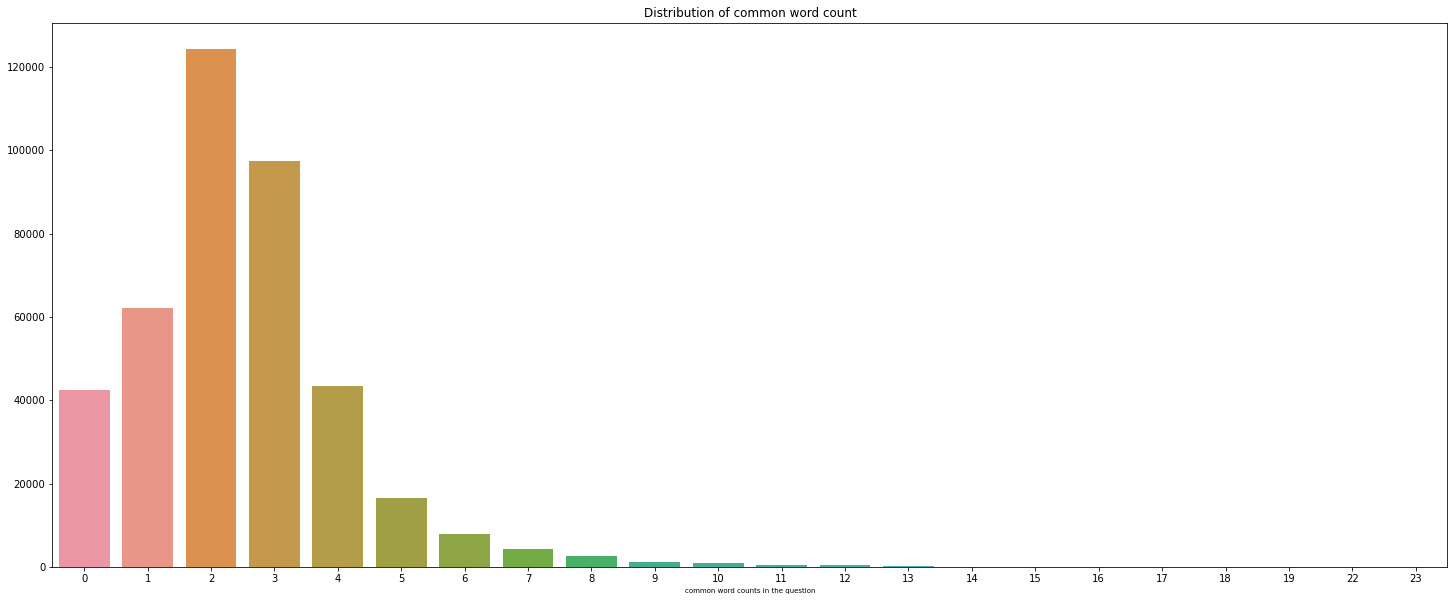

In [33]:
plt.subplots(figsize = (25,10))
sns.barplot(unigram_common_words.index, unigram_common_words.values)
plt.title('Distribution of common word count', fontsize = 12)
plt.xlabel('common word counts in the question', fontsize=7)
plt.show()

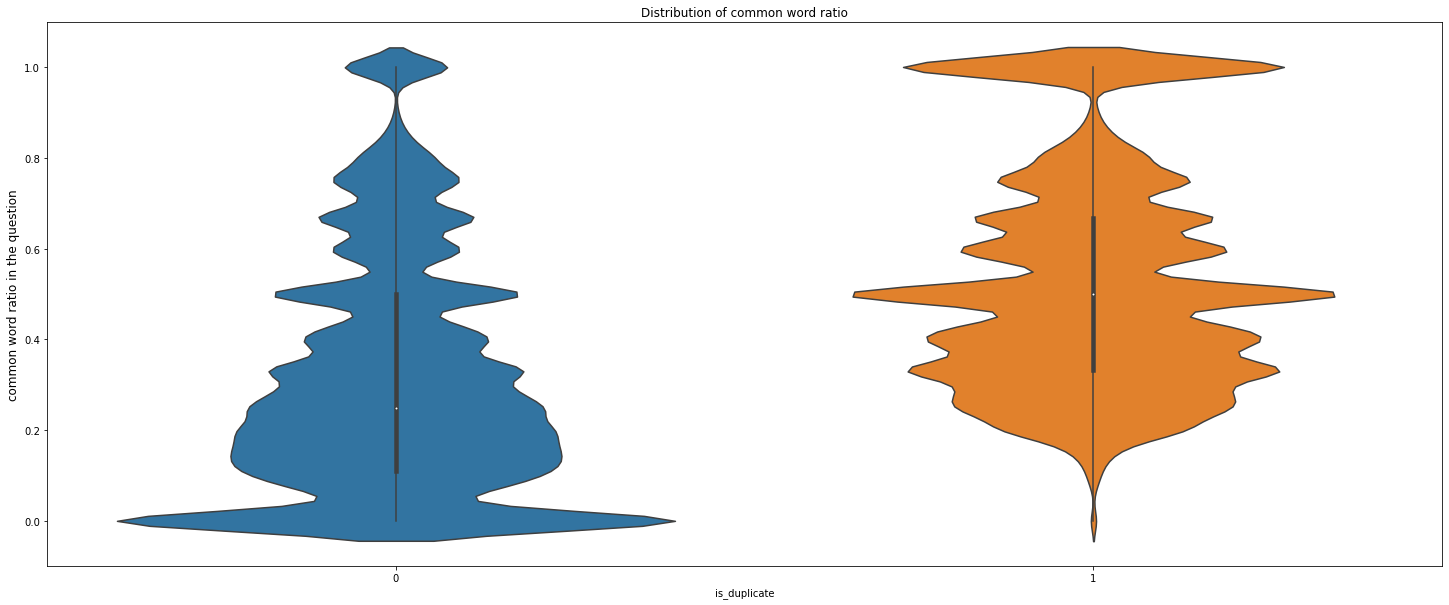

In [34]:
plt.subplots(figsize = (25,10))
sns.violinplot(x = 'is_duplicate', y = 'common_word_ratio', data = df_clean2)
plt.title('Distribution of common word ratio', fontsize = 12)
plt.ylabel('common word ratio in the question', fontsize=12)
plt.show()

# FEATURE ENGINEERING

In [35]:


df = df_clean2.sample(frac=0.4).reset_index(drop=True)

In [38]:
def removeStopWord(word):
  token=word.split(" ")   ## coverting string to token (list of word) \\ like ["this","is","token"]
  removestop=[snow.stem(x) for x in token if x not in stop_words]   ##removing stopwords and also doing Stemming
  removed=" ".join(removestop)  ##joing back the list into sentence
  return removed

In [39]:
df['cleanQ1']=df['question1'].apply(removeStopWord)
df['cleanQ2']=df['question2'].apply(removeStopWord)

In [40]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,unigram_ques1,unigram_ques2,q1len,q2len,q1_n_words,q2_n_words,word_share,common_word_ratio,cleanQ1,cleanQ2
0,170914,264196,74871,what are the most effective ways to increase twitter followers and traffic for free,what are some amazing twitter hacks strategies tools etc to receive more followers and more engagement with tweets favorites retweets,0,"[increase, traffic, ways, followers, free, effective, twitter]","[engagement, favorites, tools, followers, etc, hacks, receive, retweets, twitter, strategies, amazing, tweets]",84,134,15,21,2,0.117647,effect way increas twitter follow traffic free,amaz twitter hack strategi tool etc receiv follow engag tweet favorit retweet
1,281705,57258,401507,why should cigarettes not be banned,should cigarettes be banned,0,"[banned, cigarettes]","[banned, cigarettes]",36,28,7,5,2,1.000000,cigarett ban,cigarett ban
2,313301,437861,437862,what are some tips on making it through the job interview process at nrg yield,what are some tips on making it through the job interview process at nrg energy,0,"[interview, job, process, making, tips, yield, nrg]","[interview, job, process, making, tips, nrg, energy]",79,80,16,16,6,0.750000,tip make job interview process nrg yield,tip make job interview process nrg energi
3,339040,466631,466632,how do i memorise facts and figures of static gk for mba entrance exams,how do i memorise facts and figures of static as well as dynamic gk for mba entrance exams,1,"[entrance, memorise, mba, gk, facts, exams, static, figures]","[entrance, well, memorise, mba, dynamic, gk, facts, exams, static, figures]",72,91,15,19,8,0.800000,memoris fact figur static gk mba entranc exam,memoris fact figur static well dynam gk mba entranc exam
4,302999,426082,426083,what is skagen,what are skagen watches like,0,[skagen],"[like, skagen, watches]",15,29,4,6,1,0.333333,skagen,skagen watch like


In [43]:
df['fuzz_ratio'] = df.apply(lambda x : fuzz.ratio(x['cleanQ1'],x['cleanQ2']), axis=1)
df['Partial_Ratio']=df.apply(lambda x: fuzz.partial_ratio(x['cleanQ1'],x['cleanQ2']) ,axis=1)
df['Token_Sort_Ratio']=df.apply(lambda x: fuzz.token_sort_ratio(x['cleanQ1'],x['cleanQ2']) ,axis=1)

df['Token_Set_Ratio']=df.apply(lambda x: fuzz.token_set_ratio(x['cleanQ1'],x['cleanQ2']) ,axis=1)

Text(0.5, 1.0, 'Distribution of Fuzz Ratio')

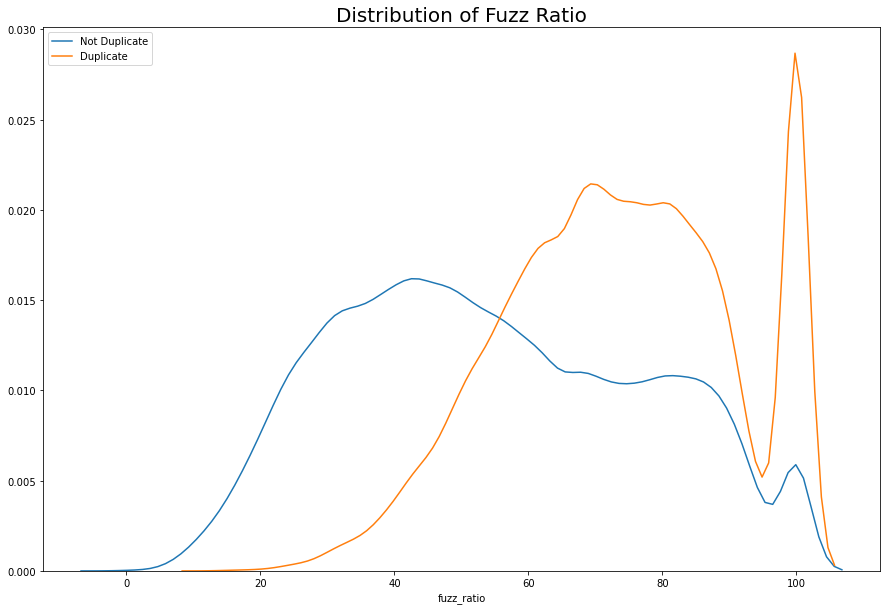

In [44]:
plt.subplots(figsize = (15,10))
sns.distplot(df[df.is_duplicate == 0].fuzz_ratio, kde=True, hist=False, label = 'Not Duplicate')
sns.distplot(df[df.is_duplicate ==1].fuzz_ratio, kde = True, hist=False, label = 'Duplicate')
plt.title('Distribution of Fuzz Ratio', size = 20)

Text(0.5, 1.0, 'Distribution of Partial Fuzz Ratio')

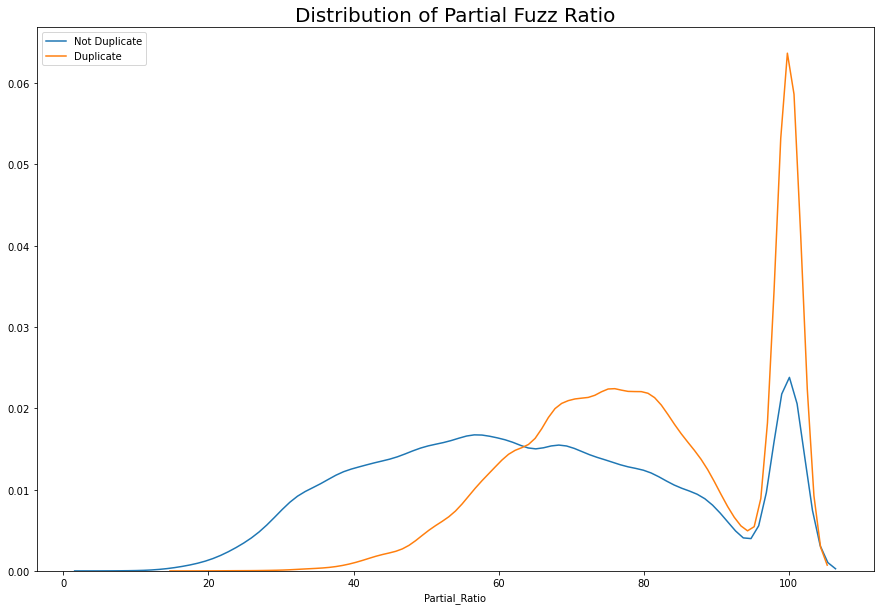

In [45]:
plt.subplots(figsize = (15,10))
sns.distplot(df[df.is_duplicate == 0].Partial_Ratio, kde=True, hist=False, label = 'Not Duplicate')
sns.distplot(df[df.is_duplicate ==1].Partial_Ratio, kde = True, hist=False, label = 'Duplicate')
plt.title('Distribution of Partial Fuzz Ratio', size = 20)

Text(0.5, 1.0, 'Distribution of Word Share')

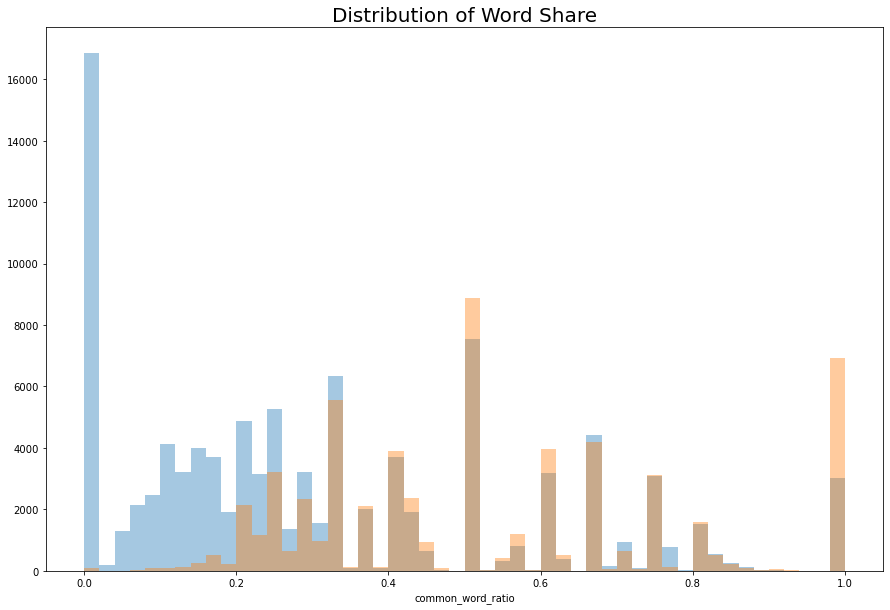

In [46]:
plt.subplots(figsize = (15,10))
sns.distplot(df[df.is_duplicate == 0].common_word_ratio, kde=False, hist=True, label = 'Not Duplicate')
sns.distplot(df[df.is_duplicate ==1].common_word_ratio, kde = False, hist=True, label = 'Duplicate')
plt.title('Distribution of Word Share', size = 20)

In [47]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'unigram_ques1', 'unigram_ques2', 'q1len', 'q2len', 'q1_n_words',
       'q2_n_words', 'word_share', 'common_word_ratio', 'cleanQ1', 'cleanQ2',
       'fuzz_ratio', 'Partial_Ratio', 'Token_Sort_Ratio', 'Token_Set_Ratio'],
      dtype='object')

In [48]:
df_data = df[['id', 'is_duplicate', 'common_word_ratio', 'fuzz_ratio', 'Partial_Ratio', 'Token_Sort_Ratio', 
         'Token_Set_Ratio', 'cleanQ1', 'cleanQ2']]

In [49]:
df_data.head()

,id,is_duplicate,common_word_ratio,fuzz_ratio,Partial_Ratio,Token_Sort_Ratio,Token_Set_Ratio,cleanQ1,cleanQ2
0,170914,0,0.117647,40,40,49,47,effect way increas twitter follow traffic free,amaz twitter hack strategi tool etc receiv follow engag tweet favorit retweet
1,281705,0,1.000000,100,100,100,100,cigarett ban,cigarett ban
2,313301,0,0.750000,89,88,84,92,tip make job interview process nrg yield,tip make job interview process nrg energi
3,339040,1,0.800000,89,76,89,100,memoris fact figur static gk mba entranc exam,memoris fact figur static well dynam gk mba entranc exam
4,302999,0,0.333333,56,100,52,100,skagen,skagen watch like


In [50]:
df=df_data[['cleanQ1','cleanQ2','is_duplicate']]
df['cleanQ1'] = df['cleanQ1'].apply(lambda x: str(x))
df['cleanQ2'] = df['cleanQ2'].apply(lambda x: str(x))

<ipython-input-50-57abb631de09>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleanQ1'] = df['cleanQ1'].apply(lambda x: str(x))
<ipython-input-50-57abb631de09>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleanQ2'] = df['cleanQ2'].apply(lambda x: str(x))


In [54]:
# merging questions of both Q1 and Q2 to a single list in which first 404287 index will be of question 1 and then rest of question 2
questions = list(df['cleanQ1']) + list(df['cleanQ2'])  # len(questions): 808574  [404287 of q1 and 404287 of q2]

tfidf = TfidfVectorizer() #  Convert a collection of raw documents to a matrix of TF-IDF features

tfidf.fit_transform(questions)  # Converting out text to a matrix of TF-IDF features

# mapping our feature_names with threre resptive tf-idf score  ( dict key:word and value:tf-idf score )
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [55]:
# Plotting Key Value Pair
wrd=list(word2tfidf.keys())[::-1][:10]   # finding keys of dict and then reversing them to get last 10 keys
for i in wrd:
    print(i,word2tfidf[i])

zzzz 12.992771127125913
zzzquil 12.076480395251759
zz 12.992771127125913
zyzz 12.992771127125913
zyrtec 12.587306019017749
zynga 11.48869373034964
zyl 12.992771127125913
zygot 12.29962394656597
zycus 12.29962394656597
zy 12.992771127125913


In [58]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []

for qu1 in tqdm(list(df['cleanQ1'])):
    
    doc1 = nlp(qu1) #creating object of   GLOVE model  so that we can get vetor representation of our words
    
    # Creating a matrix of N x M where N is is number of word is given line and M i.e. 96 which is the vector representaion of 1st word
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    
    # Looping to all words in the given sentence 
    
    for word1 in doc1:
        
       # word2vec ( Creating Vector Representation of every word ) which is 96
    
        vec1 = word1.vector
        
        # Using try and catch to prefent key error [ For the words that are not there in our word2tfidf dict like empty space ]
        
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        
        # adding up all the words generated in the matrix (word2vec matrix * the word2tfidf Corresponding to that word)
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)  # Storing the vector representation of every sentence into an array
df['q1_feats_m'] = list(vecs1)

100%|██████████| 161582/161582 [13:53<00:00, 193.82it/s]
<ipython-input-58-a611cba2f2aa>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['q1_feats_m'] = list(vecs1)


In [59]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs2 = []

for qu2 in tqdm(list(df['cleanQ2'])):
    
    doc2 = nlp(qu2) #creating object of   GLOVE model  so that we can get vetor representation of our words
    
    # Creating a matrix of N x M where N is is number of word is given line and M i.e. 96 which is the vector representaion of 1st word
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    
    # Looping to all words in the given sentence 
    
    for word2 in doc2:
        
       # word2vec ( Creating Vector Representation of every word ) which is 96
    
        vec2 = word2.vector
        
        # Using try and catch to prefent key error [ For the words that are not there in our word2tfidf dict like empty space ]
        
        try:
            idf = word2tfidf[str(word2)]
        except:
            idf = 0
        
        # adding up all the words generated in the matrix (word2vec matrix * the word2tfidf Corresponding to that word)
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)  # Storing the vector representation of every sentence into an array
df['q2_feats_m'] = list(vecs2)

100%|██████████| 161582/161582 [13:56<00:00, 193.23it/s]
<ipython-input-59-b74d79ec72aa>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['q2_feats_m'] = list(vecs2)


In [60]:
df.head()

,cleanQ1,cleanQ2,is_duplicate,q1_feats_m,q2_feats_m
0,effect way increas twitter follow traffic free,amaz twitter hack strategi tool etc receiv follow engag tweet favorit retweet,0,"[7.369928359985352, 32.91226005554199, -70.42131787911057, -12.470786228775978, 0.9737744331359863, 15.10919052362442, -29.80086273699999, 27.52245783805847, 39.20406645536423, 6.575355052947998, ...","[44.89062210917473, 126.37207913398743, -31.22503662109375, -38.551591992378235, -11.811100780963898, 37.05484253168106, -112.99180662631989, 42.45248135924339, 115.07635933160782, -35.08738952875..."
1,cigarett ban,cigarett ban,0,"[17.004796981811523, 11.825027704238892, -17.553329944610596, -2.715330123901367, 14.152068138122559, 10.409548282623291, 3.0029829144477844, 20.29914879798889, 38.39643669128418, 13.3888106346130...","[17.004796981811523, 11.825027704238892, -17.553329944610596, -2.715330123901367, 14.152068138122559, 10.409548282623291, 3.0029829144477844, 20.29914879798889, 38.39643669128418, 13.3888106346130..."
2,tip make job interview process nrg yield,tip make job interview process nrg energi,0,"[-32.38714408874512, 142.81381177902222, -90.93518075346947, -8.751358211040497, 6.59789115190506, 1.3001269549131393, 55.508787870407104, 9.590306758880615, 44.69219100475311, -22.7087412327528, ...","[-19.556401044130325, 60.68103504180908, -100.48555009067059, -12.647637367248535, -1.9550354778766632, 34.788243636488914, 72.70414954423904, -2.1038312911987305, 38.66722655296326, -21.605473518..."
3,memoris fact figur static gk mba entranc exam,memoris fact figur static well dynam gk mba entranc exam,1,"[-7.2447749376297, 74.37426030635834, -70.28525936603546, -64.02057886123657, -5.291972875595093, -6.682897448539734, 19.18460500240326, -1.0776917934417725, 92.47776556015015, -4.675854921340942,...","[22.18988585472107, 87.81806182861328, -50.32020300626755, -65.5791540145874, 22.753594160079956, 19.00514256954193, 42.477825582027435, -21.532922387123108, 102.36875438690186, 29.058832436800003..."
4,skagen,skagen watch like,0,"[10.931180000305176, 32.000667572021484, -57.63768768310547, 2.5063488483428955, 0.1104378029704094, 21.70454978942871, 10.485525131225586, -0.24338851869106293, 24.47365379333496, 19.556962966918...","[-12.41604945063591, 36.68008315563202, -64.60877871513367, 32.315035343170166, -6.370554864406586, 15.026759535074234, 17.995827674865723, 17.981563568115234, 25.790966510772705, 18.4729986786842..."


In [61]:
df1 = df_data.drop(['cleanQ1', 'cleanQ2'], axis=1)

In [62]:
df3 = df.drop(['cleanQ1', 'cleanQ2', 'is_duplicate'],axis=1)

In [63]:
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [64]:
df3_q1['id']=df1['id']
df3_q2['id']=df1['id']
#df1  = df1.merge(df2, on='id',how='left')
df2  = df3_q1.merge(df3_q2, on='id',how='left')
result  = df1.merge(df2, on='id',how='left')
